# Tiles Unsplitter script
Script que permite revertir el proceso de Splitting (divisón de imagen y etiquetas en mosaicos), para poder reconstruir la predicción sobre una imagen al agregar las inferencias realizadas para cada uno de los mosaicos.

In [ ]:
# Standard library imports
import os
import sys
import shutil
import copy
import re
import time
import math
import unicodedata
import warnings
from itertools import product
from datetime import datetime

# Third-party library imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Helper functions

In [92]:
# Handy icons for user warnings
#  🆕🆗✅❌🚫⛔️❔❓❕❗️➕✔️📂📁🗃️🗄️⏸️🚨

### Security

In [93]:
# DECORATOR FOR INPUT SANITIZATION
# Safety Mesaures for verfying potential harmful user inputs

def remove_accents(input_str):
    """Replace accents from a string with equivalent letter, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn(f"Accents were removed from input. ('{original_str}' -> '{result}')", UserWarning)

    return result

def sanitize_filename(input_str):
    """Sanitizes a filename by removing accents and disallowed characters."""
    input_str = remove_accents(input_str)  # Remove accents first
    result = input_str

    # Checks for prohibited characters (then deletes them)
    # allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    allowed_chars = r"^[a-zA-Z0-9_\-\./]+$" # Allow '/' in user input
    if not re.fullmatch(allowed_chars, input_str):
        result = re.sub(allowed_chars, "", input_str)  # Sanitize (remove invalid chars)
        warnings.warn(f"This argument is unsafe. A sanitized version will be used instead. ('{input_str}' -> '{result}')", UserWarning)

    #if input_str == result:
    #    print("Original name: '", input_str)
    #    print("Sanitized name: '", result)
    #    print()

    return result

# Decorator wrapper
def validate_filenames():
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Arguments Sanitization 
            sanitized_args = []
            for arg in args:
                if isinstance(arg, str):
                    original_arg = arg
                    sanitized_arg = sanitize_filename(arg) # Sanitize argument
                    if sanitized_arg != original_arg:
                        warnings.warn(f"Argument '{original_arg}' sanitized to '{sanitized_arg}'.", UserWarning)
                else:
                    sanitized_arg = arg
                    # warnings.warn(f"Argument '{arg}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_args.append(sanitized_arg)

            # Keyword Arguments Sanitization 
            sanitized_kwargs = {}
            for key, value in kwargs.items():
                if isinstance(value, str):
                    original_value = value
                    sanitized_value = sanitize_filename(value) # Sanitize value for keyword
                    if sanitized_value != original_value:
                        warnings.warn(f"Keyword argument '{key}'='{original_value}' sanitized to '{sanitized_value}'.", UserWarning)
                else:
                    sanitized_value = value
                    # warnings.warn(f"Argument '{value}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_kwargs[key] = sanitized_value

            # Return sanitized arguments
            return func(*sanitized_args, **sanitized_kwargs)
        return wrapper
    return decorator


In [94]:
def timestamp(message=''):
    currenttime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if message:
        print(message, currenttime, sep=": ")
    else:
        print('Timestamp', currenttime, sep=": ")

### File management

In [95]:
@validate_filenames()
def create_dir(folder_path):
    # 1) Verifica si el directorio existe y confirma si es necesario vaciarlo
    if os.path.exists(folder_path):
        print(f"🚨ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.")
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el directorio '{folder_path}' y su contenido? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            shutil.rmtree(folder_path)  # Elimina el directorio y todo su contenido
            print("> Directorio eliminado:\n",folder_path)
        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()
    else:
        print("🆕 El directorio no existe, se creará uno nuevo: '",{folder_path})
        
    # 2) Crea el directorio especificado
    os.makedirs(folder_path, exist_ok=True)
    print("✅ El directorio ya está disponible:\n",{folder_path})

In [96]:
@validate_filenames()
def empty_dir(folder_path):
    """
    Elimina todo el contenido (archivos y subdirectorios) de una carpeta especificada.

    Args:
        folder_path: La ruta de la carpeta que se va a limpiar.

    Raises:
        FileNotFoundError: Si la carpeta especificada no existe.
        OSError: Si ocurre un error durante la eliminación de archivos o directorios.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❗️La carpeta '{folder_path}' no existe.")

    try:
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el contenido de '{folder_path}'? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            for file in os.listdir(folder_path):  # Itera sobre los archivos y directorios
                file_path = os.path.join(folder_path, file)  # Crea la ruta completa

                if os.path.isfile(file_path):  # Si es un archivo
                    os.remove(file_path)  # Elimina el archivo
                    #print(f"Archivo eliminado: {file_path}")

                elif os.path.isdir(file_path):  # Si es un directorio
                    shutil.rmtree(file_path)  # Elimina el directorio y su contenido de forma recursiva
                    #print(f"Directorio eliminado: {file_path}")

            print("✔️ Contenido de la carpeta eliminado:\n", folder_path)

        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()

    except OSError as e:
        raise OSError(f"🚫 Error al limpiar la carpeta:\n {e}")    
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")

In [ ]:
# VERSIÓN MODIFICADA (in/out invertido respecto a TilesSplitter script)
@validate_filenames()
def build_filename(dset: str = '', dtype: str = '', dir: str='in', name: str | None = None, prefix: str = '', verbose: bool = False) -> str:
    """ 
    Construye el nombre y ruta necesaria para cargar/guardar cada archivo del dataset.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - dtype (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.
        - prefix (str): Establece un prefijo para el nombre del archivo (ej:'tile00x00.').
        - verbose (bool): Ofrece información verbal al usuario.

    Retorna:
        - str: Por defecto entrega la ruta de la carpeta (del dataset de entrada o salida).
        - Si además se incluye 'dset' o 'dtype', entrega el directorio de la subcarpeta correspondiente.
        - Si se incluye un nombre de archivo, devuelve la ruta con el formato adecuado.
    """
    
    # Function Example:
    #    - in: "/data/raw/3.5m.v3i.yolov8/valid/labels/
    #            209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - out: "/data/processed/3.5m.v3i.yolov8/valid/labels/
    #            tile00x00.209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - shape: /data/{dir}/{PATH}{dsuffix}/{dset}/{dtype}/ <- Folder path
    #             {prefix}.{filename}.{dtype}        <- Full filename

    # INITIALIZER LOGIC
    # Verifies that every input has the correct type
    assert (isinstance(name, str | None)
            and isinstance(dset, str)
            and isinstance(dtype, str)
            and isinstance(prefix, str)
            and isinstance(dir, str)), "❕All arguments must be strings."

    try:
        PATH
    except NameError:
        raise NameError("❗️ PATH constant is not defined.")
    try:
        OUTPUT_SUFFIX
    except NameError:
        raise NameError("❗️ OUTPUT_SUFFIX constant is not defined.")
    try:
        POINTER
    except NameError:
        raise NameError("❗️ POINTER constant is not defined.")
    
    # Normalize inputs
    dset = dset.lower()
    dtype = dtype.lower()
    dir = dir.lower()

    # This help splitting the name in half
    # for inserting the prefix next to photo filename (ej: 209_205_50_JPG)
    #POINTER = '.rf.' # could be modified for differente tag name formats
    pointer_idx = name.find(POINTER) if name != None else ""

    # Default folders and extensions
    dset_map = {
        'train': 'train/',
        'valid': 'valid/',
        'test': 'test/'
    }
    # Handle both plural and singular inputs
    dtype_map = {
        'image': ('images', 'jpg'),
        'images': ('images', 'jpg'),
        'label': ('labels', 'txt'),
        'labels': ('labels', 'txt')
    }

    def get_dset_path(dset_val: str) -> str:
        if dset_val not in dset_map:
            raise ValueError("❕Invalid 'dset': must be 'train', 'valid', or 'test'. (Empty by default)")
        return dset_map[dset_val]

    def get_dtype_info(dtype_val: str) -> tuple[str, str]:
        if dtype_val not in dtype_map:
            raise ValueError("❕Invalid 'type': must be 'image' or 'label'. (Empty by default)")
        return dtype_map[dtype_val]
    
    # FILENAME CREATION LOGIC
    # Output dataset logic
    if dir == 'in':
        root = PATH.replace('raw','processed')
        if OUTPUT_SUFFIX:
            root = f"{root[:-1]}{OUTPUT_SUFFIX}/"

        base_path = f"{root}{get_dset_path(dset)}" if dset else root
        
        if dtype:
            type_folder, extension = get_dtype_info(dtype)
            base_path = f"{base_path}{type_folder}/"
        else:
            type_folder, extension = "",""

        print("✔️ Dataset root created successfully") if verbose else ""
        #return f"{base_path}{filename}" # Ending for 'out' option
    
    # Input dataset logic
    elif dir == 'out':
        root = PATH
        base_path = f"{root}{get_dset_path(dset)}{get_dtype_info(dtype)[0]}/"
        _, extension = get_dtype_info(dtype)
        
    else:
        raise ValueError("❕Invalid 'dir': must be 'in' (default) or 'out'.")
    
    # PREFIX LOGIC
    # Managing filename prefixes
    if name is None or name == '':
        filename = ''
        print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
    else:
        if not prefix:
            # If no prefix is defined, it keeps the original name
            filename = f"{name}.{extension}"
        else:
            if pointer_idx == -1:
                # When the reference in name format is not found, it adds the prefix at the end
                filename = f"{name}.{prefix}.{extension}"
                print(f"⚠ The oiriginal file does not follow the expected format. Filenames should inlcude a '{POINTER}' reference inside.\nTherefore, the indicated prefix value '{prefix}' will be added at the end of the current filename.") if verbose else ''
            else:
                # If the format is ok, it inserts the prefix in between the original JPG filename and the hash part
                name_jpg = name[:pointer_idx]
                name_hash = name[pointer_idx:]
                filename = f"{name_jpg}.{prefix}{name_hash}.{extension}"
    
    #print("Input:", PATH, "Output:", root)
    print("✔️ Filename created succesfully") if verbose else ""
    return f"{base_path}{filename}"

In [99]:
def filenames_for_tiles(dset: str, dtype: str, dir: str='in', name: str | None = None) -> callable:
    """ 
    Crea una función anidada para generar nombres de archivo y ruta para cada mosaico.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - dtype (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.

    Retorna:
        - callable: Retorna la función generadora anidada.
    """
    def generate_filename(prefix: str = '') -> str:
        """
        Construye el nombre y ruta para el mosaico especificado.
        """
        return build_filename(dset=dset, dtype=dtype, dir=dir, prefix=prefix, name=name, verbose=False)

    return generate_filename  # Return the nested function

In [100]:
@validate_filenames()
def save_labels(dest_labels_file: str, export: pd.DataFrame, verbose: bool = True) -> bool:
    """
    Saves a DataFrame to a file, with each row as a space-separated string.

    Args:
        dest_labels_file: Path to the output file.
        export: DataFrame to save.

    Returns:
        True if the file was saved successfully, False otherwise.
    """
    try:
        lines = label_to_str(export)
        with open(dest_labels_file, 'w') as file:
            file.writelines(line + "\n" for line in lines)
        if verbose:
            print("El archivo de etiquetas se ha creado correctamente. Se han guardado todos los datos.")
        return True
    
    except OSError as e:
        raise OSError(f"🚫 Error al copiar la carpeta:\n {e}")
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")


### Formatting

In [101]:
def label_to_str(export: pd.DataFrame) -> list[str]:
    
    """
    Converts each row of a dataframe into string format

    Parameters:
    - Dataframe with labels (np.dataframe)

    Returns:
    - List with labels in text (list[str])
    """
    
    lines = []
    for _, row in export.iterrows():
        row_list = list(row)
        row_list[0] = int(row_list[0])
        line = ' '.join(map(str, row_list))
        lines.append(line)
        
    # Verificar que la cantidad de lineas coincide con la cantidad de labels
    if not len(lines) == len(export):
        raise ValueError("🚨 CUIDADO: el número de etiquetas en el archivo de salida y el dataframe no coinciden.")

    return lines

In [ ]:
def get_index(row:int , column:int ) -> int:
    """
    Calcula el índice lineal en una estructura de datos de los mosaicos definidos en el setup inicial.

    Parámetros:
    - row: Número de fila (entero).
    - column: Número de columna (entero).

    Salida:
    - Índice lineal calculado. 
    """
    if not isinstance(COLUMNS, int):
        raise TypeError(f"❕La constante columna no está definida adecuadamente. (value:{COLUMNS})")
    if not isinstance(row, int) or not isinstance(column, int):
        raise TypeError("❕Debe introducir valores enteros para fila y columna.")
    if row < 0 or column < 0:
        raise ValueError("❕Fila y columna deben ser valores no negativos.")

    return column + (row * COLUMNS)

In [103]:
def to_origin(labels: pd.DataFrame, coord: list):
    """
    Lleva las coordenadas a la ordenada para que la gráfica sea comparativa
    """
    labels = labels.copy()
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord * 2
    return labels

In [371]:
def label_transform(df_labels: pd.DataFrame, mode: str, im_height: int, im_width: int, round: bool = True) -> pd.DataFrame:
    """
    Transforms bounding box coordinates based on the specified mode.

    Args:
        df_labels: DataFrame containing bounding box coordinates (x, y, width, height).
        mode: Transformation mode ('absolute' or 'relative').
        im_height: Image height in pixels.
        im_width: Image width in pixels.
        round: Enable/Disable output rounding (default True).

    Returns:
        Transformed DataFrame with bounding box coordinates.

    Raises:
        AssertionError: If im_width or im_height is not an integer.
        ValueError: If mode is not 'absolute' or 'relative'.
    """

    assert isinstance(im_width, int), "Dimensions should be int numbers."
    assert isinstance(im_height, int), "Dimensions should be int numbers."
    assert isinstance(mode, str), "Mode should be a string"    
    assert isinstance(df_labels, pd.DataFrame), "df_labels must be a pandas DataFrame"
    
    if im_height == 0 or im_width == 0:
        raise ValueError("❕Debe introducir las dimensiones de la imagen (no pueden ser 0).")
    if mode == 'absolute':
        df_labels_abs = df_labels * [1, im_width, im_height, im_width, im_height]
        if round:
            df_labels_abs = df_labels_abs.round(0).astype(int)
        df_labels_abs['class_id'] = df_labels_abs['class_id'].astype(int)
        
        return df_labels_abs
    elif mode == 'relative':
        df_labels_rel = df_labels / [1, im_width, im_height, im_width, im_height]
        df_labels_rel['class_id'] = df_labels_rel['class_id'].astype(int)
        return df_labels_rel
    else:
        raise ValueError("❕Debe indicar el modo de transformación deseado ('absolute' o 'relative')")

In [105]:
def lbl_to_bb(df_input: pd.DataFrame) -> pd.DataFrame:

    """
    Transforma un DataFrame de 'Etiquetas' a 'Bounding Boxes'.
    
    Args:
        df_input: Dataframe de coordenadas de Labels (x, y, width, height).
        
    Returns:
        df_output: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
    """
    
    # Extraer los valores como arrays NumPy (evita el overhead de Pandas)
    class_id = df_input['class_id'].values
    x_center, y_center = df_input[['x_center', 'y_center']].to_numpy().T
    width, height = df_input[['width', 'height']].to_numpy().T

    # Calcular coordenadas de bounding box de manera vectorizada
    x0 = np.ceil(x_center - width / 2)
    x1 = np.floor(x_center + width / 2)
    y0 = np.ceil(y_center - height / 2)
    y1 = np.floor(y_center + height / 2)

    # Crear el DataFrame con los resultados optimizados
    return pd.DataFrame({'class_id': class_id, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}).astype(int)


def bb_to_lbl(df_input: pd.DataFrame) -> pd.DataFrame:
    
    """
    Transforma un DataFrame de 'Bounding Boxes' a 'Etiquetas'.
    
    Args:
        df_input: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
        
    Returns:
        df_output:  Dataframe de coordenadas de Labels (x, y, width, height).

    """

    # Extraer los valores de las coordenadas de los Bounding Boxes como arrays NumPy
    class_id = df_input['class_id'].values
    x0, x1 = df_input['x0'].values, df_input['x1'].values
    y0, y1 = df_input['y0'].values, df_input['y1'].values

    # Calcular las coordenadas del centro usando NumPy
    x_center = np.ceil((x0 + x1) / 2)
    y_center = np.ceil((y0 + y1) / 2)

    # Calcular el ancho (width) y la altura (height) usando NumPy
    width = x1 - x0
    height = y1 - y0

    # Crear el DataFrame con los resultados optimizados usando NumPy
    return pd.DataFrame({
        'class_id': class_id, 
        'x_center': x_center, 
        'y_center': y_center, 
        'width': width, 
        'height': height
    }).astype(int)

### Visualization tools

In [106]:
def draw_points(image: np.ndarray, df_labels: pd.DataFrame):
    """
    Dibuja en la imagen los centroides de cada Bounding Box.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - df_labels: pd.DataFrame -> DataFrame con columnas ['class_id','x_center', 'y_center', 'width', 'height'].
    """
    
    im_points = image.copy()
    
    # Dibujar puntos
    for _, row in df_labels.iterrows():
        x = row['x_center']
        y = row['y_center']
        point = [x, y]
        
        # Dibujar los círculos
        cv.circle(im_points, center=point, radius=7, color=(255, 0, 0), thickness=-1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [107]:
def draw_bb(image: np.ndarray, labels: pd.DataFrame, coord: tuple | list | str=(0, 0, 240, 240)):
    """
    Dibuja bounding boxes en una imagen basándose en las etiquetas proporcionadas.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - labels: pd.DataFrame -> DataFrame con columnas ['x0', 'y0', 'x1', 'y1', 'class_id'].
    - coord: tuple | list | str -> Coordenadas del tile en formato (x0, y0, x1, y1).    
    """
    im_points = image.copy()

    # Convertir `coord` a una lista de enteros si es necesario
    if isinstance(coord, str):
        coord = [int(x) for x in coord.split()]
    elif isinstance(coord, tuple):
        coord = list(coord)
    elif not isinstance(coord, list):
        raise ValueError("❗️La variable de coordenadas  debe ser una lista, tupla o string con coordenadas.")

    # Verificar que `coord` tenga 4 valores
    if len(coord) != 4:
        raise ValueError("❗️La variable de coordenadas debe contener exactamente 4 valores (x0, y0, x1, y1).")

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    #labels['x0', 'y0', 'x1', 'y1'] = to_origin(labels[['x0', 'y0', 'x1', 'y1']], coord[:2])
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2
    
    # Generar colores únicos para cada class_id
    unique_classes = labels['class_id'].unique()  # Obtener clases únicas
    color_map = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
    
    # Dibujar puntos
    for _, label in labels.iterrows():
        label.class_id
        
        color = color_map[label.class_id]
        Pi = (label.x0, label.y0)
        Po = (label.x1, label.y1)
        
        # Dibujar los círculos
        cv.rectangle(im_points, Pi, Po, color=color, thickness=1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [108]:
def test_label(tile , box):
    # Input format: x0 y0 x1 y1
    tile_coords = tile.split()
    box_coords = box.split()

    # Transforma las coordenadas ingresadas por el usuario de str a list[int]
    tile_coords = [int(x) for x in tile_coords]
    box_coords = [int(x) for x in box_coords]
    ref_coords = tile_coords.copy()

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    tile_coords = [box - tile for box, tile in zip(tile_coords, ref_coords[:2] * 2)]
    box_coords = [box - tile for box, tile in zip(box_coords, ref_coords[:2] * 2)]
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(3, 3))
    
    #                +------------------+
    #                |                  |
    #              height               |
    #                |                  |
    #               (xy)---- width -----+
    
    # anchor: x0, y1
    # width: x1 - x0
    # height: y1- y0
    
    # Dibujar tile (rojo)
    tile_rect = plt.Rectangle((tile_coords[0], tile_coords[1]), # anchor (xy)
                              tile_coords[2] - tile_coords[0], # width
                              tile_coords[3] - tile_coords[1], # height
                              edgecolor='red', facecolor='none', linewidth=2)                              
    # Dibujar box (azul)
    box_rect = plt.Rectangle((box_coords[0], box_coords[1]), 
                             box_coords[2] - box_coords[0], 
                             box_coords[3] - box_coords[1], 
                             edgecolor='blue', facecolor='none', linewidth=2)
    
    # Agregar los rectángulos a la gráfica
    ax.add_patch(tile_rect)
    ax.add_patch(box_rect)
    
    # Configurar límites y aspecto
    ax.set_xlim(-10, max(tile_coords[2], box_coords[2]) + 10)
    ax.set_ylim(-10, max(tile_coords[3], box_coords[3]) + 10)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plt.axis('off')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

### Utils

In [ ]:
# Decorador para medir el tiempo de ejecución
def duration(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Momento de inicio
        result = func(*args, **kwargs)  # Ejecuta la función
        end_time = time.time()  # Momento de fin
        execution_time = end_time - start_time  # Calcula el tiempo de ejecución
        print(f"\nTiempo de ejecución de {func.__name__}: {execution_time:.6f} segundos")
        return result
    return wrapper

In [ ]:
def gimme_path_info(path: str, verbose: bool = False) -> list:

    """
    Parses a file path, optionally prints information about its components, and returns a list of the path's folders and file name.

    Args:
        path (str): The file path to be processed.
        verbose (bool, optional): A boolean flag that controls whether to print detailed information about the path. Defaults to False.

    Returns:
        list: A list containing the individual folders and file name that make up the path.

    Raises:
        TypeError: If the input path is not a string.
        ValueError: If the path is empty.
    """
    if not isinstance(path, str):
        raise TypeError("Input path must be a string.")
    if not path:
        raise ValueError("Input path cannot be empty.")

    try:
        folders = path.split("/")
        file_level = len(folders) - 1
        _, ext = os.path.splitext(path)

        if verbose:
            for idx, folder in enumerate(folders):
                if idx == file_level and ext != '':
                    print(f"File:", folder)
                else:
                    print(f"Level {idx}:", folder)

        return folders

    except Exception as e:
        # Catch any unexpected errors during path processing.
        print(f"❗️ An error occurred: {e}")
        return [] # Return an empty list in case of error.

In [188]:
def gimme_filename_info(file: str, ext: bool = False) -> dict:

    """
    Extracts information from a filename, including prefix, base filename, tile, 
    RoboFlow pointer, hash, and extension.

    Args:
        file: The input filename string.
        ext: If True, also extracts the file extension. Defaults to False.

    Returns:
        A dictionary containing the extracted components of the filename.
    Raises:
        NameError: If FILENAME or POINTER constants are not defined.
        ValueError: If FILENAME or POINTER are not found in the filename.
    """


    try:
        PROCESSING_FILE
    except NameError:
        raise NameError("❗️ PROCESSING_FILE constant is not defined.")

    try:
        POINTER
    except NameError:
        raise NameError("❗️ POINTER constant is not defined.")

    if ext:
        # Realiza un split de la extensión
        labels_file, file_ext = os.path.splitext(file)
    else:
        labels_file = file
        file_ext = ''

    # Define el nombre base
    global FILENAME 
    FILENAME = PROCESSING_FILE[:PROCESSING_FILE.find(POINTER)]
    FILENAME = FILENAME.split(".")[0]

    # Verifica si existe algún prefijo
    prefix_idx = labels_file.find(FILENAME)
    prefix_odx = prefix_idx+len(labels_file[0:prefix_idx])

    # Nombre del archivo base
    filename_idx = labels_file.find(FILENAME)
    filename_odx = filename_idx+len(FILENAME)

    # Referencia de RoboFlow (pre-hash)
    #POINTER = '.rf.'
    pointer_idx = labels_file.find(POINTER)
    pointer_odx = pointer_idx+len(POINTER)

    # Expresa los valores
    #print("Filename:",labels_file,"\n")

    components = {
        'Prefix': labels_file[prefix_idx:prefix_odx],
        'Filename': labels_file[filename_idx:filename_odx],
        'Tile': labels_file[filename_odx+1:pointer_idx],
        'Pointer': labels_file[pointer_idx:pointer_odx],
        'Hash': labels_file[pointer_odx:],
        'Extension': file_ext
    }

    return components

# Procesamiento del dataset

## Settings
Set every parameter for the dataset you need to process

In [112]:
# Dataset split to work with
subset_opt = ['train','valid']
type_opt = ['image', 'label']

# Should not be defined by user (security)
PATH_LOCATION = '../../'

# Modify it in case tag files format changes
POINTER = '.rf.'

timestamp('Modified at')

Modified at: 2025-03-02 11:09:58


In [113]:
# CONFIGURAR DATASET A PROCESAR
DATASET_NAME = '3.5m.v3i.yolov8'
SUBSET = subset_opt[1] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-02 11:09:58


In [114]:
# CONFIGURAR PARÁMETROS DE PROCESAMIENTO
S = 640 # Tile size
OUTPUT_SUFFIX = ".640px" # Optional (leave empty if not needed)
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-02 11:09:58


## Ejecución inicial
Debe ejecutarse sólo una vez al iniciar el proceso

In [115]:
PATH = f'{PATH_LOCATION}data/raw/{DATASET_NAME}/'
print("Directorio:", PATH)
input_dir = build_filename(SUBSET,'image')
timestamp()

Directorio: ../../data/raw/3.5m.v3i.yolov8/
Timestamp: 2025-03-02 11:09:58


### Safety check for user inputs

In [116]:
#===========================================================#
#                                                           #
#    DO NOT include PATH_LOCATION, otherwise the script     #
#       won't be able to find the right folder path         #
#                                                           #
#===========================================================#

# Verifica parámetros constantes seteadas por el usuario
for file in [DATASET_NAME, SUBSET, PATH]:
    result = sanitize_filename(file)
    
# Verifica otras variables dependientes de input de usuario
# Evita posibles rutas que puedan representar un punto de ataque

timestamp('Checked at')


Checked at: 2025-03-02 11:09:58


## Procesamiento de cada archivo 
Debe ejecutarse de forma iterativa hasta finalizar el proceso

### Run once per subset

In [117]:
#Intialize variables
order = 0
files = []

In [118]:
# SUBSET = subset_opt[0] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-02 11:09:58


In [119]:
DATASET_NAME = PATH[PATH.find('raw')+4:-1]
input_dir = build_filename(SUBSET,'image')

try:
    files = os.listdir(input_dir)
    files = [file for file in files if file != ".DS_Store"]
    files = [os.path.splitext(file)[0] for file in files]

    timestamp()

    print("Dataset: ", DATASET_NAME)
    print(f"Listing files for '{SUBSET}' set\n")
    print("Indexes: 0 -",len(files)-1)
except FileNotFoundError:
    print(f"Error: La carpeta '{input_dir}' no fue encontrada.")

files

Timestamp: 2025-03-02 11:09:58
Dataset:  3.5m.v3i.yolov8
Listing files for 'valid' set

Indexes: 0 - 107


['209_310_37_JPG.tile03x00.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile02x06.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile02x08.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_205_50_JPG.tile05x08.rf.949b5aa6fdbf6a1f721c39ed5ddcebec',
 '209_205_50_JPG.tile05x06.rf.949b5aa6fdbf6a1f721c39ed5ddcebec',
 '209_310_37_JPG.tile01x02.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_205_50_JPG.tile04x00.rf.949b5aa6fdbf6a1f721c39ed5ddcebec',
 '209_310_37_JPG.tile00x04.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile00x05.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_205_50_JPG.tile04x01.rf.949b5aa6fdbf6a1f721c39ed5ddcebec',
 '209_310_37_JPG.tile01x03.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_205_50_JPG.tile05x07.rf.949b5aa6fdbf6a1f721c39ed5ddcebec',
 '209_310_37_JPG.tile02x07.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile03x01.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile03x03.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_310_37_JPG.tile02x0

### Iterar desde aquí

In [120]:
# SELECCIONAR ARCHIVO A PROCESAR
PROCESSING_FILE = files[order]
print (f'Índice {order}:\n', PROCESSING_FILE)
print()
timestamp()

Índice 0:
 209_310_37_JPG.tile03x00.rf.fc1bab0d312b2f3ded60d51f809b6a2d

Timestamp: 2025-03-02 11:09:58


In [121]:
order += 1
if order == len(files):
    print("🚨ALERTA: se procesará el último archivo")

In [180]:
gimme_filename_info(PROCESSING_FILE)

{'Prefix': '',
 'Filename': '209_310_37_JPG',
 'Tile': 'tile03x00',
 'Pointer': '.rf.',
 'Hash': 'fc1bab0d312b2f3ded60d51f809b6a2d',
 'Extension': ''}

In [ ]:
#FILENAME = PROCESSING_FILE[:PROCESSING_FILE.find(POINTER)]
#FILENAME = FILENAME.split(".")[0]

In [186]:
FILENAME

'209_310_37_JPG'

### Visualiza imagen seleccionada

In [181]:
components = gimme_filename_info(PROCESSING_FILE)
if 'Tile' in components:
    del components['Tile']
UNSPLITTED_IMG = "".join(components.values())

print('Root image:', UNSPLITTED_IMG)
timestamp()

Root image: 209_310_37_JPG.rf.fc1bab0d312b2f3ded60d51f809b6a2d
Timestamp: 2025-03-02 11:25:27


In [175]:
image_file = build_filename(SUBSET,'image',name=UNSPLITTED_IMG, dir="out")

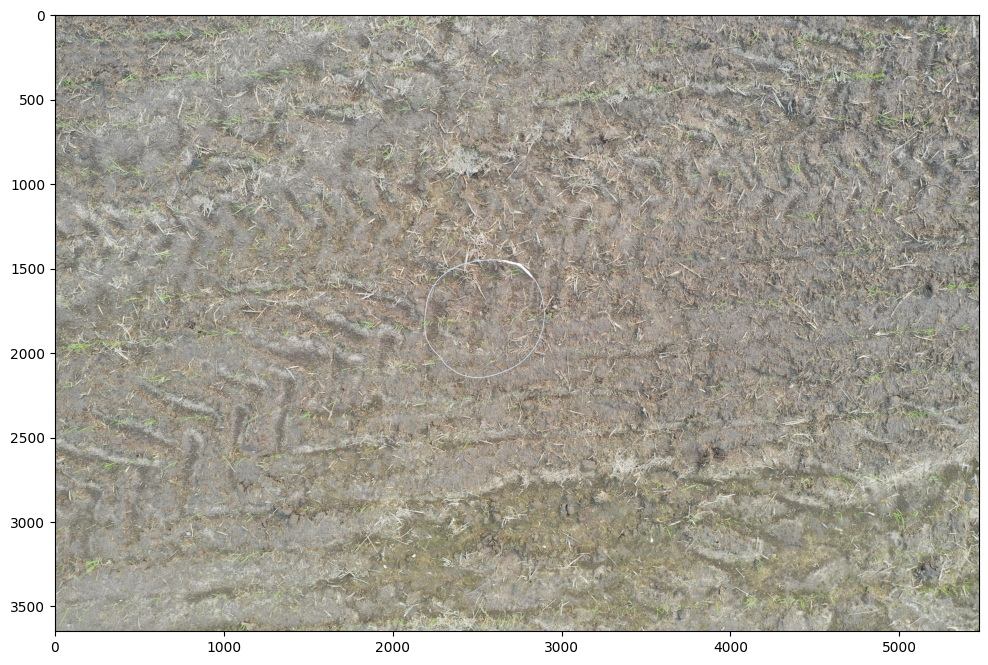

In [177]:
image = cv.imread(image_file)

im = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

In [189]:
H, W, _ = im.shape
im.shape
#(height, width, channels) 

(3648, 5472, 3)

# Reconstrucción de Etiquetas *(Joining Tiles)*

Al tratarse de la reconstrucción de las predicciones realizadas, ya se dispone de la imagen original, por lo que sólo será necesario realizar el procesamiento de las etiquetas.

In [190]:
ROWS = math.ceil(H/S) # Rows
COLUMNS = math.ceil(W/S) # Columns
ROWS, COLUMNS

(6, 9)

In [191]:
print("Se dividirá la imagen en {:,} tiles".format(ROWS * COLUMNS))

Se dividirá la imagen en 54 tiles


## Agrega borde negro para ajustar las dimensiones
### *(sobre la imagen original)*

In [192]:
# Dimensiones del archivo original en px
im.shape

(3648, 5472, 3)

In [193]:
center = True

if center:
    # Centra la imagen y agrega alrededor un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, math.floor((S * ROWS - H)/2), math.ceil((S * ROWS - H)/2),
                                math.floor((S * COLUMNS - W)/2),  math.ceil((S * COLUMNS - W)/2),
                                cv.BORDER_CONSTANT, (0,0,0)
                               )
    # Calcular offset por redimensión de la imagen
    y_offset = math.floor((S * ROWS - H)/2)
    x_offset = math.floor((S * COLUMNS - W)/2)
    
else:
    # Agrega al final de la imagen un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, 0, (S * ROWS - H), 0, (S * COLUMNS - W), cv.BORDER_CONSTANT, (0,0,0))
    
    # Informa que no existe offset en la imagen
    x_offset = 0
    y_offset = 0

In [194]:
x_offset, y_offset

(144, 96)

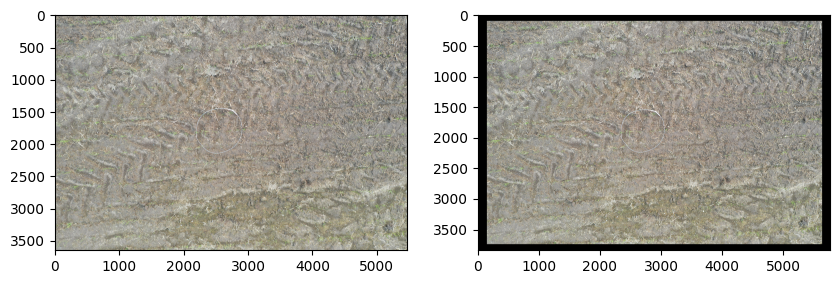

In [195]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(im_fill)
plt.show()

In [196]:
# Se verifica que la división en tiles da un entero
a, b, _ = im_fill.shape
a/S, b/S

(6.0, 9.0)

In [197]:
# Dimensiones del archivo en px (con borde negro)
im_fill.shape

(3840, 5760, 3)

## Reconstruye la grilla de mosaicos

In [392]:
tiles = [[0] * COLUMNS for _ in range(ROWS)]
tiles_dim = [[0] * COLUMNS for _ in range(ROWS)]
x0, x1, y0, y1 = 0, 0, 0, 0
count = 0

for row in range(ROWS):  # Filas primero
    for column in range(COLUMNS):  # Luego columnas
        x0 = S * column  # Basado en la columna
        y0 = S * row  # Basado en la fila
        x1 = S * (column + 1)
        y1 = S * (row + 1)
        
        # Ahora ambos tienen el mismo orden de indices
        tiles_dim[row][column] = (x0, y0, x1, y1) # Almacena la grilla de dimensiones
        
        count += 1

timestamp()

Timestamp: 2025-03-02 20:08:27


# Importación de Predicciones

**Objetivo:** Distribuir los BB para que coincidan con cada mosaico de 240x240px

__*ATENCIÓN*__ no deben perderse BB que aparecen entre 2 tiles.

### Offset setup

In [198]:
# Verifica el offset de por redimensión de imagen (borde negro)
if im_fill.shape[:2] == (H + y_offset * 2, W + x_offset * 2):
    print("Se ha verificado el offset de la imagen.") 
else:
    print("CUIDADO: Verificar offset de la imagen.")
x_offset, y_offset

Se ha verificado el offset de la imagen.


(144, 96)

### Import predictions (inference for every tile)

In [323]:
labels_path = build_filename(dset=SUBSET, dtype='label', name=PROCESSING_FILE, dir="in")

In [324]:
# Se listan todos los archivos correspondientes a la imagen a procesar
files = os.listdir(labels_path)
imported_tags = [file for file in files if file.startswith(FILENAME)]
imported_tags = sorted(imported_tags)

In [355]:
# Se importan las etiquetas de cada archivo
labels = []
predictions = []

for labels_file in imported_tags:
    file_path = f"{labels_path}/{labels_file}"
    with open(file_path, 'r') as file:
        # Extra cada predicción del archivo
        lines = file.readlines()
        lines = [line.strip() for line in lines]
        labels = [line.split() for line in lines]
        labels = [[int(value) if i == 0 else float(value) for i, value in enumerate(label)] for label in labels]
        df_labels = pd.DataFrame(labels, columns=['class_id', 'x_center', 'y_center', 'width', 'height'])
        # Extrae Row/Column del nombre de archivo importado

        info = gimme_filename_info(labels_file,True)
        info = info['Tile'][len('tile'):].split("x")
        row = int(info[0])
        column = int(info[1])
        predictions.append({
            'row': row,
            'column': column,
            'data': df_labels
            })

In [341]:
predictions[0]['data']

,class_id,x_center,y_center,width,height
0,0,0.939063,0.717187,0.121875,0.068750
1,0,0.943750,0.756250,0.112500,0.037500
2,0,0.304688,0.781250,0.081250,0.059375
3,0,0.331250,0.781250,0.065625,0.068750
4,0,0.390625,0.770312,0.115625,0.084375
5,0,0.531250,0.795312,0.090625,0.040625
6,0,0.631250,0.792188,0.096875,0.034375
7,0,0.853125,0.334375,0.125000,0.065625
8,0,0.754687,0.307812,0.059375,0.028125
9,0,0.628125,0.387500,0.103125,0.040625


In [405]:
max_row = 0
max_col = 0
for prediction in predictions:
    row = prediction['row']
    if row > max_row:
        max_row  = row
    col = prediction['column']
    if col > max_col:
        max_col  = col
print(max_row,max_col)

5 8


In [ ]:
# Filtrado para análisis (NO NECESARIO)
for pred in predictions:
    if 8 <= pred['column'] <=9:
        if 5 <= pred['row'] <=6:
            print(pred['row'], pred['column'])

5 8


In [407]:
#Se verifica que las dimensiones de la lista coinciden con las de los tiles deseados
print("     ","rows", "cols")
print("tiles:", max_row+1,",", max_col+1)
print("dims: ", len(tiles_dim),",", len(tiles_dim[0]))

      rows cols
tiles: 6 , 9
dims:  6 , 9


class_id | x_center | y_center | width | height (normalized values)

### Absolute values

In [342]:
W, H

(5472, 3648)

In [380]:
predictions[0]['data'].head(3)

,class_id,x_center,y_center,width,height
0,0,0.939063,0.717187,0.121875,0.068750
1,0,0.943750,0.756250,0.112500,0.037500
2,0,0.304688,0.781250,0.081250,0.059375


In [ ]:
# Se transforma el formato de relativo a absoluto
predictions_abs = copy.deepcopy(predictions)
for i, prediction in enumerate(predictions):
    predictions_abs[i]['data'] = label_transform(prediction['data'], 'absolute', im_height=S, im_width=S)

In [381]:
predictions_abs[0]['data'].head(3)

,class_id,x_center,y_center,width,height
0,0,601,459,78,44
1,0,604,484,72,24
2,0,195,500,52,38


### Bounding Boxes calculation

In [389]:
predictions_abs[0]['data'].head(5)

,class_id,x_center,y_center,width,height
0,0,601,459,78,44
1,0,604,484,72,24
2,0,195,500,52,38
3,0,212,500,42,44
4,0,250,493,74,54


In [387]:
# Se transforma el formato de relativo a absoluto
predictions_BB = copy.deepcopy(predictions_abs)
for i, prediction in enumerate(predictions_abs):
    predictions_BB[i]['data'] = lbl_to_bb(prediction['data'])

In [388]:
predictions_BB[0]['data'].head(5)

,class_id,x0,x1,y0,y1
0,0,562,640,437,481
1,0,568,640,472,496
2,0,169,221,481,519
3,0,191,233,478,522
4,0,213,287,466,520


### Joining labels

In [408]:
tiles_dim[2][3]

(1920, 1280, 2560, 1920)

In [427]:

for row in range(ROWS):
    for column in range(COLUMNS):
        for index, prediction in enumerate(predictions_BB):
            if prediction['row'] > 4:
                print("found")
                #print(prediction['data'].head(1))

found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
found
foun

In [347]:
print(f"Iniciando proceso de recorte de etiquetas…\n")
verbose = False
bb_tiles = []
count = 0
total_labels = 0
df_BBoxes_hist = []


with tqdm(total = ROWS*COLUMNS, desc="Processing Tiles") as pbar: 
    for row in range(ROWS):
        for column in range(COLUMNS):
            # Establece variables iniciales
            add_labels = []
            tile = tiles[row][column]
            tile_dim = tiles_dim[row][column]
    
            # Cálculo de coordenadas de referencia
            x0, y0, x1, y1 = tile_dim # Pi, Po
            Pi = (x0, y0)
            Po = (x1, y1)
    
            print('NUEVO MOSAICO:', "\n", x0, y0, x1, y1, "\n") if verbose else ""

            for index, label in df_BBoxes.iterrows():
                # Para cada etiqueta, verifica si se encuentra dentro del mosaico
                # Devuelve True si el punto se encuentra dentro del mosaico
                #     x0  x0+1   x1-2   x1-1 
                #     |<-------------->      Pi
                #         <-------------->|  Po
                val_x0 = True if x1-1 > label.x0 >= x0 else False
                val_y0 = True if y1-1 > label.y0 >= y0 else False
                val_x1 = True if x0 < label.x1 < x1 else False
                val_y1 = True if y0 < label.y1 < y1 else False
                
                # Verifica si el punto de inicio/final se encuentra dentro del mosaico
                val_Pi = True if (val_x0 and val_y0) else False
                val_Po = True if (val_x1 and val_y1) else False
                
                if val_Pi and val_Po:
                    #Incluye la etiqueta sin procesarla
                    if True:
                        print(count, index,":", "Se incluye la etiqueta sin procesarla") if verbose else ""
                        print('tile:', x0, y0, x1, y1) if verbose else ""
                        print('label:', label.x0,label.y0,label.x1,label.y1, "\n") if verbose else ""
                    add_labels.append(label)
                    
                elif val_Pi or val_Po:
                    # Procesa la etiqueta para incluir solo los px que pertenecen al tile
                    new_label = label.copy()
                    
                    if val_Pi:
                        print("Caso 1: inicio dentro") if verbose else ""
                        # Reemplaza final de etiqueta por borde del tile
                        if not val_x1:
                            new_label.x1 = x1
                        if not val_y1:
                            new_label.y1 = y1
                            
                    if val_Po:
                        print("Caso 2: final dentro") if verbose else ""
                        # Reemplaza inicio de etiqueta por borde del tile
                        if not val_x0:
                            new_label.x0 = x0
                        if not val_y0:
                            new_label.y0 = y0
                            
                    add_labels.append(new_label)
                    print(count, index,":", "Se ha recortado la etiqueta") if verbose else ""
                    print('original:', label.x0,label.y0,label.x1,label.y1) if verbose else ""
                    print('new:', new_label.x0,new_label.y0,new_label.x1,new_label.y1, "\n") if verbose else ""
                    
                else:
                    print(count, index,":", "La etiqueta no pertenece al mosaico") if verbose else ""
                    print('tile:', x0, y0, x1, y1) if verbose else ""
                    print('label:', label.x0,label.y0,label.x1,label.y1, "\n") if verbose else ""
            
            # Almacena las etiquetas válidas para ese mosaico
            add_labels = pd.DataFrame(add_labels, columns=['class_id', 'x0', 'y0', 'x1', 'y1'])
            new_tile = {
                'dims': tile_dim,
                'labels': add_labels,
                'tile': tile
            }
            bb_tiles.append(new_tile)
            
            #print(f"    #{count} Se han agregado {len(add_labels)} etiquetas\n")
            print() if verbose else ""
            total_labels += len(add_labels)
            count += 1
            df_BBoxes_hist.append(df_BBoxes)

            pbar.update(1)  # Update the progress bar after each tile is processed

print(f"\nPROCESO FINALIZADO:\n✅ Se han agregado un total de {total_labels} etiquetas ({total_labels/index*100:.2f}%)")
timestamp()

Iniciando proceso de recorte de etiquetas…



Processing Tiles: 100%|██████████| 54/54 [00:02<00:00, 19.87it/s]


PROCESO FINALIZADO:
✅ Se han agregado un total de 996 etiquetas (107.33%)
Timestamp: 2025-02-25 00:27:31


### Offset labels (FINAL)

In [ ]:
x_offset, y_offset

(144, 96)

In [ ]:
# Se realiza el desplazamiento de las etiquetas
predictions_abs = copy.deepcopy(predictions)
for i, prediction in enumerate(predictions):
    predictions_abs[i]['data'] = label_transform(prediction['data'], 'absolute', im_height=S, im_width=S)

In [ ]:
df_labels_off = df_labels_abs - [0, x_offset, y_offset, 0, 0]
df_labels_off.head(3)

,class_id,x_center,y_center,width,height
0,0,5599,1827,34,20
1,0,5358,1850,56,11
2,0,5303,1856,25,13


# Verificación del proceso

In [453]:
# VALIDACIÓN DEL OUTPUT

# Verificamos que en todas las iteraciones se conserva el total de etiquetas dentro del dataframe
comp = sum(len(box) for box in df_BBoxes_hist)
check = comp / len(df_BBoxes_hist)
assert check == len(df_BBoxes), "¡Error: no se han recorrido todos los labels!"

# Verificamos que no se hayan perdido etiquetas en el proceso
assert total_labels >= len(df_labels), "¡Error: se han perdido etiquetas!"

# Verificamos que en ningún punto se hayan invertido las coordenadas por error
for index in range(len(bb_tiles)):
    assert all(label.x0 <= label.x1 for _, label in bb_tiles[index]['labels'].iterrows()), "¡Error: x0 > x1!"
    assert all(label.y0 <= label.y1 for _, label in bb_tiles[index]['labels'].iterrows()), "¡Error: y0 > y1!"
# NOTA: Esto lanzará un error si x0 > x1 o y0 > y1

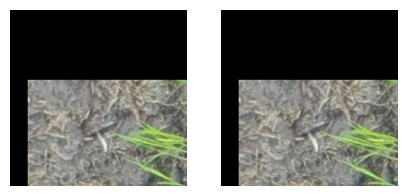

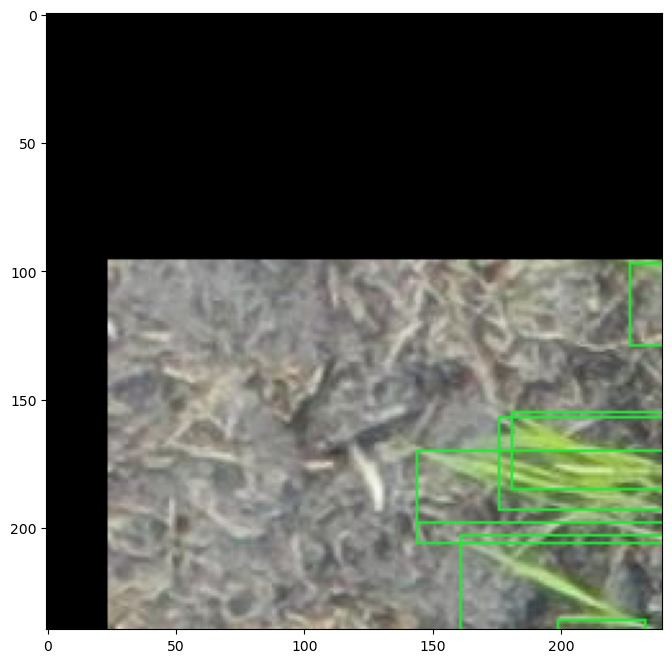


 indice 0 : (0, 0) 



,class_id,x0,y0,x1,y1
0,0,161,203,240,240
1,0,199,236,233,240
3,0,144,170,240,206
4,0,144,170,240,198
5,0,176,157,240,193
6,0,181,155,240,185
987,0,227,97,240,129


In [ ]:
# Para recorrer cada valor de la matriz
row = 0 # tope 15
column = 0 # tope 22
# rows/columns: (16, 23)
index = get_index(row,column)

# 2) Visualización del mosaico:
# Se verifica que la imagen correspondiente sea la correcta
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
axes[0].imshow(tiles[row][column])
axes[1].imshow(bb_tiles[index]['tile'])
axes[0].axis("off")
axes[1].axis("off")

# 1) Visualización de las etiquetas procesadas:
# Se verifica que cada etiqueta corresponda con un objeto de la imagen

# Se deben enviar copias del array y dataframe por ser objetos mutables
draw_bb(np.copy(bb_tiles[index]['tile']),
        bb_tiles[index]['labels'].copy(),
        bb_tiles[index]['dims'])


# 3) Visualización de valores:
# Se verifica que cada coordenada efectivamente esté dentro del mosaico.
print("\n","indice",index,":",bb_tiles[index]['dims'][:2],"\n")
bb_tiles[index]['labels']


# Exportación de la predicción

## ❌ Almacenamiento de imágenes (NO NECESARIO)

In [ ]:
# Creates mested function for generating every tile filename iteratively
generate_tile_filename = filenames_for_tiles(dset=SUBSET, 
                                             dtype='image',
                                             dir='out', 
                                             name=PROCESSING_FILE)

In [349]:
# Guarda las imágenes con manejo de errores
try:
    for row in range(ROWS):
        for column in range(COLUMNS):
            # Creation of filename for current tile
            #name = os.path.join(output_dir, f"tile{row:02d}x{column:02d}.JPG")
            tile_prefix = f"tile{row:02d}x{column:02d}"
            name = generate_tile_filename(tile_prefix)

            # Preparation of data to store
            index = get_index(row,column)
            data = bb_tiles[index]['tile']

            # Check if the tile data is valid (e.g., not None)
            if data is None:
                print(f"⚠️ Tile data is None for {name}, skipping.")
                continue  # Skip to the next tile

            # Convert from RGB to BGR if necessary
            if data.shape[2] == 3: # Check if it has 3 channels (color image)
                file_data = cv.cvtColor(data, cv.COLOR_RGB2BGR)
            else:
                file_data = data # If it's grayscale, no conversion needed

            success = cv.imwrite(name,file_data)
            
            if not success:
                file_name = name[(name.find('images'))+7:]
                print(f"🚫 Error al guardar:\n {file_name}")
                
except Exception as e:
    print(f"❌ Error inesperado: {e}")
else:
    print("✅ Todas las imágenes se guardaron correctamente.")
    timestamp()

✅ Todas las imágenes se guardaron correctamente.
Timestamp: 2025-02-25 00:27:31


## Almacenamiento de etiquetas

### Adapta el formato de los datos

In [350]:
# Se ejecuta de forma iterativa dentro del siguiente script
label_transform(bb_tiles[0]['labels'],'relative', im_height=S, im_width=S)

,class_id,x0,y0,x1,y1
879,0,0.801562,0.910937,0.848437,1.000000
880,0,0.842187,0.812500,0.882812,0.846875
881,0,0.379688,0.912500,0.482812,0.953125
882,0,0.318750,0.726562,0.384375,0.785937
883,0,0.290625,0.689063,0.350000,0.729688
...,...,...,...,...,...
906,0,0.481250,0.257812,0.556250,0.310937
907,0,0.464062,0.298438,0.539062,0.342187
908,0,0.348438,0.298438,0.482812,0.332813
909,0,0.225000,0.335938,0.253125,0.364063


### Almacena los datos

**"a":**  The texts will be inserted at the current file stream position, default at the end of the file.

**"w":** The file will be emptied before the texts will be inserted at the current file stream position, default 0.

**Incluir transformación de etiquetas _(abs -> rel)_**

Detalle del proceso:
1. Utiliza las coordenadas del tile: ``bb_tiles[index]['dims']``
2. Traslada las coordenadas al origen
3. Transforma a etiquetas relativas _(x_center, y_center, width, height)_: ``bb_to_lbl(df_BBoxes)``
4. Verifica decimales de los valores

In [ ]:
# Creates mested function for generating every tile filename iteratively
generate_tile_filename = filenames_for_tiles(dset=SUBSET, 
                                             dtype='label',
                                             dir='out', 
                                             name=PROCESSING_FILE)

In [352]:
# Guarda las etiquetas con manejo de errores
try:
    for row in range(ROWS):
        for column in range(COLUMNS):

            # 1) Preparación de nombre de archivos
            #file_name = ROOT_NAME + name
            #path = os.path.join(output_dir, f"tile{row:02d}x{column:02d}.txt")
            tile_prefix = f"tile{row:02d}x{column:02d}"
            name = generate_tile_filename(tile_prefix)

            # 2) Preparación de datos a exportar
            index = get_index(row,column)
            data = bb_tiles[index]['labels'].copy() # Etiquetas a almacenar
            
            # 3) Traslada las coordenadas al origen para que coincidan con la imagen
            coord = bb_tiles[index]['dims']
            data[['x0', 'y0', 'x1', 'y1']] = data[['x0', 'y0', 'x1', 'y1']].astype(int)
            data[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2

            # 4) Transforma a etiquetas relativas (x_center, y_center, width, height)
            data = bb_to_lbl(data)
            file_data = label_transform(data,'relative', im_height=S, im_width=S)
           
            # 5) Envía los datos para guardado
            success = save_labels(name, file_data, verbose=False) 
            
            if not success:
                file_name = name[(name.find('label'))+7:]
                print(f"🚫 Error al guardar:\n {file_name}")
                
except Exception as e:
    print(f"❌ Error inesperado: {e}")
else:
    print("✅ Todas las etiquetas se guardaron correctamente.")
    timestamp()

✅ Todas las etiquetas se guardaron correctamente.
Timestamp: 2025-02-25 00:27:31


# Visualización _(para verificación)_

Se debe verificar que los centroides de los BB coinciden efectivamente con las plantas

### Imagen completa

In [78]:
draw_points(im_fill, df_labels_off)

NameError: name 'df_labels_off' is not defined

## Mosaicos + BoundingBoxes

In [ ]:
# Grafica todos los bb para cada tile generado
# CUIDADO: alto tiempo de ejecución, posible memory overflow error

for row, column in product(range(ROWS), range(COLUMNS)):  # Genera todas las combinaciones (fias/columnas)
    print(column,row)
    index = get_index(row,column)
    
    # Se deben enviar copias del array y dataframe por ser objetos mutables
    draw_bb(np.copy(bb_tiles[index]['tile']),
            bb_tiles[index]['labels'].copy(),
            bb_tiles[index]['dims'])

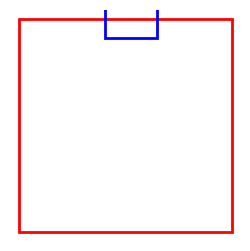

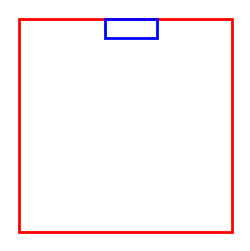

In [ ]:
tile = "0 720 240 960 "
label = "97 682 156 742"
label1 = "97 720 156 742 "
test_label(tile,label)
test_label(tile,label1)

In [ ]:
H, W

(3648, 5472)